In [56]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch

from xgboost import XGBClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

In [57]:
adult = pd.read_csv('adult.csv')
adult.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [58]:
bank_marketing = pd.read_csv('bank-full.csv',delimiter=';')
bank_marketing.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [59]:
churn = pd.read_csv('churn.csv')
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [60]:
iris = pd.read_csv('Iris.csv')
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [61]:
def run_tabnet(dataframe,x):
    
    #Prepare data
    
    data = dataframe.copy()
    
    target = data.columns[-1]
    binary = data.nunique()[-1] == 2
    print(binary)
    
    if "Set" not in data.columns:
        data["Set"] = np.random.choice(["pretrain","train", "valid", "test"], 
                                       p =[0.8-x, x, .1, .1], size=(data.shape[0],))
        
    pretrain_indices = data[data.Set=="pretrain"].index
    train_indices = data[data.Set=="train"].index
    valid_indices = data[data.Set=="valid"].index
    test_indices = data[data.Set=="test"].index
    
    #Data prep
    
    nunique = data.nunique()
    types = data.dtypes

    categorical_columns = []
    categorical_dims =  {}
    for col in data.columns:
        if types[col] == 'object' or nunique[col] < 200:
            l_enc = LabelEncoder()
            data[col] = data[col].fillna("VV_likely")
            data[col] = l_enc.fit_transform(data[col].values)
            categorical_columns.append(col)
            categorical_dims[col] = len(l_enc.classes_)
        else:
            data.fillna(data.loc[train_indices, col].mean(), inplace=True)
            
    unused_feat = ['Set']
    features = [ col for col in data.columns if col not in unused_feat+[target]] 
    cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
    cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
    
    X_pretrain = data[features].values[pretrain_indices]
    y_pretrain = data[target].values[pretrain_indices]
    
    X_train = data[features].values[train_indices]
    y_train = data[target].values[train_indices]

    X_valid = data[features].values[valid_indices]
    y_valid = data[target].values[valid_indices]

    X_test = data[features].values[test_indices]
    y_test = data[target].values[test_indices]
    
    #Pre-training
    
    unsupervised_model = TabNetPretrainer(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=3,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        mask_type='entmax',verbose=0 # "sparsemax"
    )
    
    max_epochs = 1000
    
    unsupervised_model.fit(
    X_train=X_pretrain,
    eval_set=[X_valid],
    max_epochs=max_epochs, patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,
    )
    
    #Training
    
    clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax',verbose=0 # This will be overwritten if using pretrain model
                      )
    
    eval_metric = 'auc' if binary else 'accuracy'
    
    clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=[eval_metric],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=unsupervised_model
    )
    
    if(binary):
    
        preds = clf.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

        return test_auc
    
    else:
        
        preds = clf.predict(X_test)
        test_acc = accuracy_score(y_pred=preds, y_true=y_test)
        
        return test_acc

In [62]:
def run_xgboost(dataframe,x):
    
    data = dataframe.copy()
    
    target = data.columns[-1]
    binary = data.nunique()[-1] == 2
    print(binary)
    
    if "Set" not in data.columns:
        data["Set"] = np.random.choice(["pretrain","train", "valid", "test"], 
                                       p =[0.8-x, x, .1, .1], size=(data.shape[0],))
        
    pretrain_indices = data[data.Set=="pretrain"].index
    train_indices = data[data.Set=="train"].index
    valid_indices = data[data.Set=="valid"].index
    test_indices = data[data.Set=="test"].index
    
    nunique = data.nunique()
    types = data.dtypes
    
    for col in data.columns:
        if types[col] == 'object' or nunique[col] < 200:
            l_enc = LabelEncoder()
            data[col] = data[col].fillna("VV_likely")
            data[col] = l_enc.fit_transform(data[col].values)
        else:
            data.fillna(data.loc[train_indices, col].mean(), inplace=True)
            
    unused_feat = ['Set']
    features = [ col for col in data.columns if col not in unused_feat+[target]] 
    
    X_pretrain = data[features].values[pretrain_indices]
    y_pretrain = data[target].values[pretrain_indices]
    
    X_train = data[features].values[train_indices]
    y_train = data[target].values[train_indices]

    X_valid = data[features].values[valid_indices]
    y_valid = data[target].values[valid_indices]

    X_test = data[features].values[test_indices]
    y_test = data[target].values[test_indices]
    
    model = XGBClassifier()
    
    model.fit(X_train,y_train)
    
    if(binary):
    
        preds = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)

        return test_auc
    
    else:
        
        preds = model.predict(X_test)
        test_acc = accuracy_score(y_pred=preds, y_true=y_test)
        
        return test_acc

In [63]:
def run_lightgbm(dataframe,x):
    
    data = dataframe.copy()
    
    target = data.columns[-1]
    binary = data.nunique()[-1] == 2
    print(binary)
    
    if "Set" not in data.columns:
        data["Set"] = np.random.choice(["pretrain","train", "valid", "test"], 
                                       p =[0.8-x, x, .1, .1], size=(data.shape[0],))
        
    pretrain_indices = data[data.Set=="pretrain"].index
    train_indices = data[data.Set=="train"].index
    valid_indices = data[data.Set=="valid"].index
    test_indices = data[data.Set=="test"].index
    
    nunique = data.nunique()
    types = data.dtypes
    
    for col in data.columns:
        if types[col] == 'object' or nunique[col] < 200:
            l_enc = LabelEncoder()
            data[col] = data[col].fillna("VV_likely")
            data[col] = l_enc.fit_transform(data[col].values)
        else:
            data.fillna(data.loc[train_indices, col].mean(), inplace=True)
            
    unused_feat = ['Set']
    features = [ col for col in data.columns if col not in unused_feat+[target]] 
    
    X_pretrain = data[features].values[pretrain_indices]
    y_pretrain = data[target].values[pretrain_indices]
    
    X_train = data[features].values[train_indices]
    y_train = data[target].values[train_indices]

    X_valid = data[features].values[valid_indices]
    y_valid = data[target].values[valid_indices]

    X_test = data[features].values[test_indices]
    y_test = data[target].values[test_indices]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    
    params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
    }
    
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)
    
    if(binary):
    
        preds = gbm.predict(X_test)
        test_auc = roc_auc_score(y_score=preds, y_true=y_test)
    
        return test_auc
    
    else:
        
        probs = gbm.predict(X_test)
        preds = [round(p) for p in probs]
        test_acc = accuracy_score(y_pred=preds, y_true=y_test)
        
        return test_acc

Starting TabNet for 0.01 on Iris
False

Early stopping occurred at epoch 63 with best_epoch = 58 and best_val_0_unsup_loss = 1.09602
Best weights from best epoch are automatically used!
TabNet failed on Iris for value 0.01
Starting XGBoost for 0.01 on Iris
False
[17:45:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.01 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
LightGBM failed on Iris for value 0.01
Starting TabNet for 0.02 on Iris
False


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_unsup_loss = 1.6864
Best weights from best epoch are automatically used!
TabNet failed on Iris for value 0.02
Starting XGBoost for 0.02 on Iris
False
[17:45:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.02 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1	valid_0's l2: 1.66667
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_unsup_loss = 1.12409
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.52941
Best weights from best epoch are automatically used!
Starting XGBoost for 0.03 on Iris
False
[17:45:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.03 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.375	valid_0's l2: 2.5
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0'

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_unsup_loss = 1.58619
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 1 and best_valid_accuracy = 0.375
Best weights from best epoch are automatically used!
Starting XGBoost for 0.04 on Iris
False
[17:45:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.04 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 2.09412	valid_0's l2: 4.82824
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_0_unsup_loss = 1.0078
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 13 and best_valid_accuracy = 0.5
Best weights from best epoch are automatically used!
Starting XGBoost for 0.05 on Iris
False
[17:45:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.05 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 0.8	valid_0's l2: 0.749091
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0'

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_0_unsup_loss = 1.00748
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 33 with best_epoch = 13 and best_valid_accuracy = 0.44444
Best weights from best epoch are automatically used!
Starting XGBoost for 0.06 on Iris
False
[17:45:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.06 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1	valid_0's l2: 1.83333
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0'

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_0_unsup_loss = 1.01464
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_accuracy = 0.5
Best weights from best epoch are automatically used!
Starting XGBoost for 0.07 on Iris
False
[17:45:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.07 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.03529	valid_0's l2: 1.53412
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 32 with best_epoch = 27 and best_val_0_unsup_loss = 1.02126
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.53333
Best weights from best epoch are automatically used!
Starting XGBoost for 0.08 on Iris
False
[17:45:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.08 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 0.834783	valid_0's l2: 0.96
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	val

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 30 with best_epoch = 25 and best_val_0_unsup_loss = 1.05533
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_accuracy = 0.55
Best weights from best epoch are automatically used!
Starting XGBoost for 0.09 on Iris
False
[17:45:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.09 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.15686	valid_0's l2: 1.95425
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_0_unsup_loss = 0.97558
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 16 and best_valid_accuracy = 0.47059
Best weights from best epoch are automatically used!
Starting XGBoost for 0.1 on Iris
False
[17:45:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.1 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.02222	valid_0's l2: 1.81037
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	val

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_0_unsup_loss = 1.11031
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 40 with best_epoch = 20 and best_valid_accuracy = 0.55556
Best weights from best epoch are automatically used!
Starting XGBoost for 0.11 on Iris
False
[17:45:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.11 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.35315	valid_0's l2: 2.41985
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	v

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_0_unsup_loss = 0.9723
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 2 and best_valid_accuracy = 0.6
Best weights from best epoch are automatically used!
Starting XGBoost for 0.12 on Iris
False
[17:45:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.12 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.48641	valid_0's l2: 2.79927
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_0_unsup_loss = 1.0857
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 22 with best_epoch = 2 and best_valid_accuracy = 0.58333
Best weights from best epoch are automatically used!
Starting XGBoost for 0.13 on Iris
False
[17:45:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.13 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.78571	valid_0's l2: 3.82653
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	va

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_0_unsup_loss = 1.01611
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.52381
Best weights from best epoch are automatically used!
Starting XGBoost for 0.14 on Iris
False
[17:45:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.14 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.1886	valid_0's l2: 2.15582
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	va

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_0_unsup_loss = 1.04702
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 31 with best_epoch = 11 and best_valid_accuracy = 0.58333
Best weights from best epoch are automatically used!
Starting XGBoost for 0.15 on Iris
False
[17:45:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.15 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.26061	valid_0's l2: 2.34913
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	v

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_0_unsup_loss = 1.09327
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.46667
Best weights from best epoch are automatically used!
Starting XGBoost for 0.16 on Iris
False
[17:45:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.16 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.08553	valid_0's l2: 2.03774
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	v

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_0_unsup_loss = 1.07428
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 48 with best_epoch = 28 and best_valid_accuracy = 0.81818
Best weights from best epoch are automatically used!
Starting XGBoost for 0.17 on Iris
False
[17:45:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.17 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.16667	valid_0's l2: 1.88743
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	v

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_unsup_loss = 1.18855
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 1 and best_valid_accuracy = 0.44444
Best weights from best epoch are automatically used!
Starting XGBoost for 0.18 on Iris
False
[17:45:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.18 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 0.92823	valid_0's l2: 1.26577
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	va

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_0_unsup_loss = 1.05303
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 35 with best_epoch = 15 and best_valid_accuracy = 0.5
Best weights from best epoch are automatically used!
Starting XGBoost for 0.19 on Iris
False
[17:45:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.19 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.21212	valid_0's l2: 1.91552
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_0_unsup_loss = 1.10163
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.72727
Best weights from best epoch are automatically used!
Starting XGBoost for 0.2 on Iris
False
[17:45:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.2 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 0.953846	valid_0's l2: 1.46982
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	va

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 55 with best_epoch = 50 and best_val_0_unsup_loss = 0.94054
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 21 and best_valid_accuracy = 0.5
Best weights from best epoch are automatically used!
Starting XGBoost for 0.21 on Iris
False
[17:45:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.21 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.07083	valid_0's l2: 1.95528
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 37 with best_epoch = 32 and best_val_0_unsup_loss = 1.02928
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 4 and best_valid_accuracy = 0.5
Best weights from best epoch are automatically used!
Starting XGBoost for 0.22 on Iris
False
[17:45:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.22 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.0251	valid_0's l2: 1.56574
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_unsup_loss = 1.11236
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 49 with best_epoch = 29 and best_valid_accuracy = 0.66667
Best weights from best epoch are automatically used!
Starting XGBoost for 0.23 on Iris
False
[17:45:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.23 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 0.829837	valid_0's l2: 1.17384
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_unsup_loss = 1.1732
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_accuracy = 0.5
Best weights from best epoch are automatically used!
Starting XGBoost for 0.24 on Iris
False
[17:46:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.24 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.09774	valid_0's l2: 1.77048
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 58 with best_epoch = 53 and best_val_0_unsup_loss = 1.00625
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 16 and best_valid_accuracy = 0.63636
Best weights from best epoch are automatically used!
Starting XGBoost for 0.25 on Iris
False
[17:46:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.25 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.11765	valid_0's l2: 1.82353
Training until valid

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_0_unsup_loss = 1.02724
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 10 and best_valid_accuracy = 0.66667
Best weights from best epoch are automatically used!
Starting XGBoost for 0.26 on Iris
False
[17:46:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.26 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.1834	valid_0's l2: 1.94308
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	va

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_unsup_loss = 1.06456
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 50 with best_epoch = 30 and best_valid_accuracy = 0.64706
Best weights from best epoch are automatically used!
Starting XGBoost for 0.27 on Iris
False
[17:46:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.27 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 0.894737	valid_0's l2: 1.14294
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_0_unsup_loss = 1.13221
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_accuracy = 0.5
Best weights from best epoch are automatically used!
Starting XGBoost for 0.28 on Iris
False
[17:46:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.28 on Iris
False
[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1.31622	valid_0's l2: 2.32243
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_0_unsup_loss = 1.14258
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 8 and best_valid_accuracy = 0.61538
Best weights from best epoch are automatically used!
Starting XGBoost for 0.29 on Iris
False
[17:46:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.29 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 0.914141	valid_0's l2: 1.33655
Training until valid

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_unsup_loss = 1.05343
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.73333
Best weights from best epoch are automatically used!
Starting XGBoost for 0.3 on Iris
False
[17:46:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.3 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 0.957995	valid_0's l2: 1.30111
Training until valida

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 47 with best_epoch = 42 and best_val_0_unsup_loss = 1.02124
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.57143
Best weights from best epoch are automatically used!
Starting XGBoost for 0.31 on Iris
False
[17:46:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.31 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 0.754663	valid_0's l2: 1.01242
Training until vali

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_0_unsup_loss = 1.20801
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 16 and best_valid_accuracy = 0.63636
Best weights from best epoch are automatically used!
Starting XGBoost for 0.32 on Iris
False
[17:46:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.32 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l1: 1	valid_0's l2: 1.52632
Training until validation 

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_0_unsup_loss = 1.07895
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_accuracy = 0.57143
Best weights from best epoch are automatically used!
Starting XGBoost for 0.33 on Iris
False
[17:46:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.33 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.522563	valid_0's l2: 0.492065
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 32 with best_epoch = 27 and best_val_0_unsup_loss = 1.19238
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 6 and best_valid_accuracy = 0.66667
Best weights from best epoch are automatically used!
Starting XGBoost for 0.34 on Iris
False
[17:46:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.34 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.712167	valid_0's l2: 0.667068
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_0_unsup_loss = 1.20448
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 14 and best_valid_accuracy = 0.3
Best weights from best epoch are automatically used!
Starting XGBoost for 0.35 on Iris
False
[17:46:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.35 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.585863	valid_0's l2: 0.553469
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_0_unsup_loss = 1.04873
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 7 and best_valid_accuracy = 0.53333
Best weights from best epoch are automatically used!
Starting XGBoost for 0.36 on Iris
False
[17:46:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.36 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.604792	valid_0's l2: 0.584817
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_0_unsup_loss = 1.02242
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 26 with best_epoch = 6 and best_valid_accuracy = 0.69231
Best weights from best epoch are automatically used!
Starting XGBoost for 0.37 on Iris
False
[17:46:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.37 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.670916	valid_0's l2: 0.64413
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 30 with best_epoch = 25 and best_val_0_unsup_loss = 1.01172
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 28 with best_epoch = 8 and best_valid_accuracy = 0.73333
Best weights from best epoch are automatically used!
Starting XGBoost for 0.38 on Iris
False
[17:46:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.38 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.685115	valid_0's l2: 0.652947
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 54 with best_epoch = 49 and best_val_0_unsup_loss = 1.02641
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.66667
Best weights from best epoch are automatically used!
Starting XGBoost for 0.39 on Iris
False
[17:46:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.39 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.775703	valid_0's l2: 0.74267
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 52 with best_epoch = 47 and best_val_0_unsup_loss = 1.06947
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_accuracy = 0.6875
Best weights from best epoch are automatically used!
Starting XGBoost for 0.4 on Iris
False
[17:46:23] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.4 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.507775	valid_0's l2: 0.420816
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best g

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 39 with best_epoch = 34 and best_val_0_unsup_loss = 1.14406
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.6087
Best weights from best epoch are automatically used!
Starting XGBoost for 0.41 on Iris
False
[17:46:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.41 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.620891	valid_0's l2: 0.601864
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 37 with best_epoch = 32 and best_val_0_unsup_loss = 1.08589
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 10 and best_valid_accuracy = 0.57143
Best weights from best epoch are automatically used!
Starting XGBoost for 0.42 on Iris
False
[17:46:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.42 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.740067	valid_0's l2: 0.691574
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 36 with best_epoch = 31 and best_val_0_unsup_loss = 0.99755
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_accuracy = 0.75
Best weights from best epoch are automatically used!
Starting XGBoost for 0.43 on Iris
False
[17:46:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.43 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.834822	valid_0's l2: 0.805367
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best g

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_0_unsup_loss = 1.03271
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.68421
Best weights from best epoch are automatically used!
Starting XGBoost for 0.44 on Iris
False
[17:46:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.44 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.741521	valid_0's l2: 0.705209
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 46 with best_epoch = 41 and best_val_0_unsup_loss = 1.02889
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.80952
Best weights from best epoch are automatically used!
Starting XGBoost for 0.45 on Iris
False
[17:46:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.45 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.542801	valid_0's l2: 0.50262
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_0_unsup_loss = 0.97826
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 3 and best_valid_accuracy = 0.5
Best weights from best epoch are automatically used!
Starting XGBoost for 0.46 on Iris
False
[17:46:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.46 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.751376	valid_0's l2: 0.719696
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_unsup_loss = 1.28058
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.75
Best weights from best epoch are automatically used!
Starting XGBoost for 0.47 on Iris
False
[17:46:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.47 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.608846	valid_0's l2: 0.57996
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 36 with best_epoch = 31 and best_val_0_unsup_loss = 0.98915
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 30 with best_epoch = 10 and best_valid_accuracy = 0.66667
Best weights from best epoch are automatically used!
Starting XGBoost for 0.48 on Iris
False
[17:46:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.48 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.622972	valid_0's l2: 0.586256
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 46 with best_epoch = 41 and best_val_0_unsup_loss = 1.00938
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 55 with best_epoch = 35 and best_valid_accuracy = 0.76923
Best weights from best epoch are automatically used!
Starting XGBoost for 0.49 on Iris
False
[17:46:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.49 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.706631	valid_0's l2: 0.663823
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_0_unsup_loss = 1.1466
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 39 with best_epoch = 19 and best_valid_accuracy = 0.61905
Best weights from best epoch are automatically used!
Starting XGBoost for 0.5 on Iris
False
[17:46:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.5 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.806746	valid_0's l2: 0.768455
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 37 with best_epoch = 32 and best_val_0_unsup_loss = 1.05425
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.7
Best weights from best epoch are automatically used!
Starting XGBoost for 0.51 on Iris
False
[17:46:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.51 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.66709	valid_0's l2: 0.627403
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pr


Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_unsup_loss = 1.47561
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.78571
Best weights from best epoch are automatically used!
Starting XGBoost for 0.52 on Iris
False
[17:46:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.52 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gai

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_unsup_loss = 1.08463
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 43 with best_epoch = 23 and best_valid_accuracy = 0.7
Best weights from best epoch are automatically used!
Starting XGBoost for 0.53 on Iris
False
[17:46:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.53 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.436875	valid_0's l2: 0.413291
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_unsup_loss = 1.43634
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_accuracy = 0.53846
Best weights from best epoch are automatically used!
Starting XGBoost for 0.54 on Iris
False
[17:46:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.54 on Iris
False
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.701882	valid_0's l2: 0.666826
Training until validation scores don't improve for 5 rounds

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_0_unsup_loss = 1.15418
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_accuracy = 0.55556
Best weights from best epoch are automatically used!
Starting XGBoost for 0.55 on Iris
False
[17:46:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.55 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.795437	valid_0's l2: 0.752595
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_0_unsup_loss = 1.02736
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 23 with best_epoch = 3 and best_valid_accuracy = 0.42857
Best weights from best epoch are automatically used!
Starting XGBoost for 0.56 on Iris
False
[17:46:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.56 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.595163	valid_0's l2: 0.561494
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_0_unsup_loss = 1.07959
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.61111
Best weights from best epoch are automatically used!
Starting XGBoost for 0.57 on Iris
False
[17:46:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.57 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.751728	valid_0's l2: 0.712949
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_0_unsup_loss = 1.10038
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_accuracy = 0.6875
Best weights from best epoch are automatically used!
Starting XGBoost for 0.58 on Iris
False
[17:46:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.58 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.471182	valid_0's l2: 0.435849
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 30 with best_epoch = 25 and best_val_0_unsup_loss = 0.96729
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 65 with best_epoch = 45 and best_valid_accuracy = 0.57143
Best weights from best epoch are automatically used!
Starting XGBoost for 0.59 on Iris
False
[17:46:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.59 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.463066	valid_0's l2: 0.434019
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_0_unsup_loss = 1.1626
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 5 and best_valid_accuracy = 0.66667
Best weights from best epoch are automatically used!
Starting XGBoost for 0.6 on Iris
False
[17:46:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.6 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.742667	valid_0's l2: 0.71428
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_unsup_loss = 1.13192
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 34 with best_epoch = 14 and best_valid_accuracy = 0.55556
Best weights from best epoch are automatically used!
Starting XGBoost for 0.61 on Iris
False
[17:46:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.61 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.653037	valid_0's l2: 0.614146
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_unsup_loss = 1.14838
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 27 with best_epoch = 7 and best_valid_accuracy = 0.5
Best weights from best epoch are automatically used!
Starting XGBoost for 0.62 on Iris
False
[17:46:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.62 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.717239	valid_0's l2: 0.67973
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_0_unsup_loss = 1.21948
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 12 and best_valid_accuracy = 0.47368
Best weights from best epoch are automatically used!
Starting XGBoost for 0.63 on Iris
False
[17:46:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.63 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.554151	valid_0's l2: 0.511651
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_0_unsup_loss = 1.23336
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.625
Best weights from best epoch are automatically used!
Starting XGBoost for 0.64 on Iris
False
[17:46:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.64 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.744337	valid_0's l2: 0.71481
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best g

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_0_unsup_loss = 1.06425
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 37 with best_epoch = 17 and best_valid_accuracy = 0.71429
Best weights from best epoch are automatically used!
Starting XGBoost for 0.65 on Iris
False
[17:47:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.65 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.507565	valid_0's l2: 0.469404
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_0_unsup_loss = 1.10456
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.55556
Best weights from best epoch are automatically used!
Starting XGBoost for 0.66 on Iris
False
[17:47:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.66 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.678501	valid_0's l2: 0.624694
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 33 with best_epoch = 28 and best_val_0_unsup_loss = 1.05972
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.80952
Best weights from best epoch are automatically used!
Starting XGBoost for 0.67 on Iris
False
[17:47:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.67 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.540483	valid_0's l2: 0.517484
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_unsup_loss = 1.18587
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 18 and best_valid_accuracy = 0.57895
Best weights from best epoch are automatically used!
Starting XGBoost for 0.68 on Iris
False
[17:47:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.68 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.678095	valid_0's l2: 0.626434
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_0_unsup_loss = 1.15732
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 29 with best_epoch = 9 and best_valid_accuracy = 0.70588
Best weights from best epoch are automatically used!
Starting XGBoost for 0.69 on Iris
False
[17:47:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.69 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.834028	valid_0's l2: 0.793353
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_unsup_loss = 1.37689
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 46 with best_epoch = 26 and best_valid_accuracy = 0.83333
Best weights from best epoch are automatically used!
Starting XGBoost for 0.7 on Iris
False
[17:47:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.7 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.523278	valid_0's l2: 0.492501
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best 

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_unsup_loss = 1.34893
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 57 with best_epoch = 37 and best_valid_accuracy = 0.9
Best weights from best epoch are automatically used!
Starting XGBoost for 0.71 on Iris
False
[17:47:08] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.71 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.639165	valid_0's l2: 0.600648
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best ga

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_unsup_loss = 1.24746
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 22 and best_valid_accuracy = 0.64706
Best weights from best epoch are automatically used!
Starting XGBoost for 0.72 on Iris
False
[17:47:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.72 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.492039	valid_0's l2: 0.441093
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_0_unsup_loss = 1.12799
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 21 with best_epoch = 1 and best_valid_accuracy = 0.44444
Best weights from best epoch are automatically used!
Starting XGBoost for 0.73 on Iris
False
[17:47:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.73 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.704356	valid_0's l2: 0.662808
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_0_unsup_loss = 1.0784
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.61538
Best weights from best epoch are automatically used!
Starting XGBoost for 0.74 on Iris
False
[17:47:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.74 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.535597	valid_0's l2: 0.501698
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pr

Loading weights from unsupervised pretraining

Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_accuracy = 0.66667
Best weights from best epoch are automatically used!
Starting XGBoost for 0.75 on Iris
False
[17:47:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.75 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.586057	valid_0's l2: 0.550678
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warni

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 31 with best_epoch = 26 and best_val_0_unsup_loss = 1.02108
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 24 with best_epoch = 4 and best_valid_accuracy = 0.5
Best weights from best epoch are automatically used!
Starting XGBoost for 0.77 on Iris
False
[17:47:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.77 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.598713	valid_0's l2: 0.563206
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pr

Loading weights from unsupervised pretraining

Early stopping occurred at epoch 23 with best_epoch = 3 and best_valid_accuracy = 0.58333
Best weights from best epoch are automatically used!
Starting XGBoost for 0.78 on Iris
False
[17:47:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.78 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.53143	valid_0's l2: 0.478705
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warnin

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_0_unsup_loss = 1.13072
Best weights from best epoch are automatically used!
Loading weights from unsupervised pretraining


/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_dims changed from [] to [150, 35, 23, 43, 22]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 2, 3, 4]
  warnings.warn(wrn_msg)
/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:97: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 44 with best_epoch = 24 and best_valid_accuracy = 0.64286
Best weights from best epoch are automatically used!
Starting XGBoost for 0.79 on Iris
False
[17:47:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Starting LightGBM for 0.79 on Iris
False
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 0.556478	valid_0's l2: 0.528467
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, bes

/Users/tomadams/opt/anaconda3/envs/TabNet/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


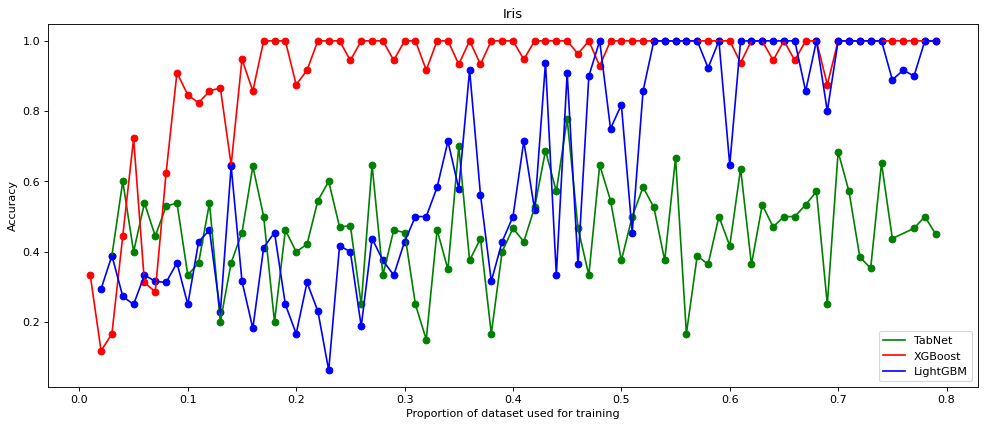

In [66]:
#datasets = {'Churn':churn,'Bank Marketing':bank_marketing,'Income':adult}
datasets = {'Iris':iris}
#test_probs = [0.4]
test_probs = [x/100 for x in list(range(1,80))]

for d in datasets:
    
    data = datasets[d].copy()
    
    binary = data.nunique()[-1] == 2
    
    tabnet_scores = []
    xgboost_scores = []
    lightgbm_scores = []
    tprobs = []
    xprobs = []
    lprobs = []
    
    for t in test_probs:
            
        try:
            print('Starting TabNet for ' + str(t) + ' on ' + d)
            tabnet_score = run_tabnet(data,t)
            tabnet_scores.append(tabnet_score)
            tprobs.append(t)
        except:
            print('TabNet failed on ' + d + ' for value ' + str(t))
            
        try:
            print('Starting XGBoost for ' + str(t) + ' on ' + d)
            xgboost_score = run_xgboost(data,t)
            xgboost_scores.append(xgboost_score)
            xprobs.append(t)
        except:
            print('XGBoost failed on ' + d + ' for value ' + str(t))
            
        try:
            print('Starting LightGBM for ' + str(t) + ' on ' + d)
            lightgbm_score = run_lightgbm(data,t)
            lightgbm_scores.append(lightgbm_score)
            lprobs.append(t)
        except:
            print('LightGBM failed on ' + d + ' for value ' + str(t))
    
    from matplotlib.pyplot import figure
    figure(figsize=(15, 6), dpi=80)
    
    plt.title(d)
    plt.plot(tprobs,tabnet_scores,color='green',label='TabNet')
    plt.plot(xprobs,xgboost_scores,color='red',label='XGBoost')
    plt.plot(lprobs,lightgbm_scores,color='blue',label='LightGBM')
    
    plt.scatter(tprobs,tabnet_scores,color='green')
    plt.scatter(xprobs,xgboost_scores,color='red')
    plt.scatter(lprobs,lightgbm_scores,color='blue')
    
    plt.xlabel('Proportion of dataset used for training')
    
    ylabel = 'AUROC Score' if binary else 'Accuracy'
    
    plt.ylabel(ylabel)
    
    plt.legend(loc='lower right')
    plt.savefig(d + '.png')